In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
import itertools
from sklearn.metrics import mean_squared_error

In [2]:
df_raw = pd.read_csv('de_train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('de_test.csv', low_memory=False, parse_dates=['date'], index_col=['date'])

In [3]:
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
df_test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [5]:
print("Train and Test shape are {} and {} respectively".format(df_raw.shape, df_test.shape))

Train and Test shape are (913000, 3) and (45000, 3) respectively


In [6]:
#### Seasonality Check
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0

In [7]:
# Preparing data by stores
sales_a = df_raw[df_raw.store==2]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.store==3]['sales'].sort_index(ascending = True)
sales_c = df_raw[df_raw.store==1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.store==4]['sales'].sort_index(ascending = True)

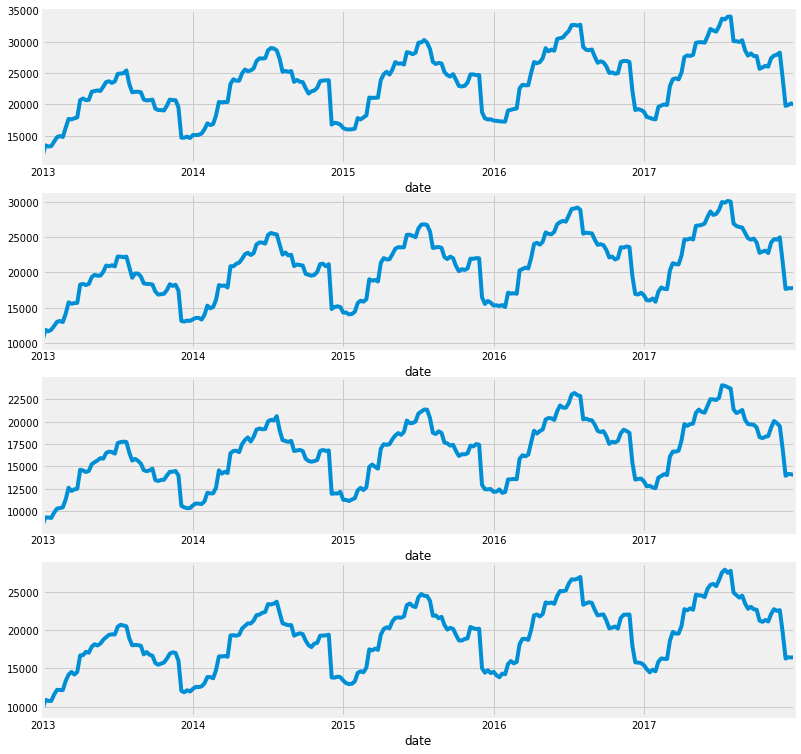

In [8]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize = (12,13))

# data is sampled by day. To plot it it need to be upsampled to weekly.

sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

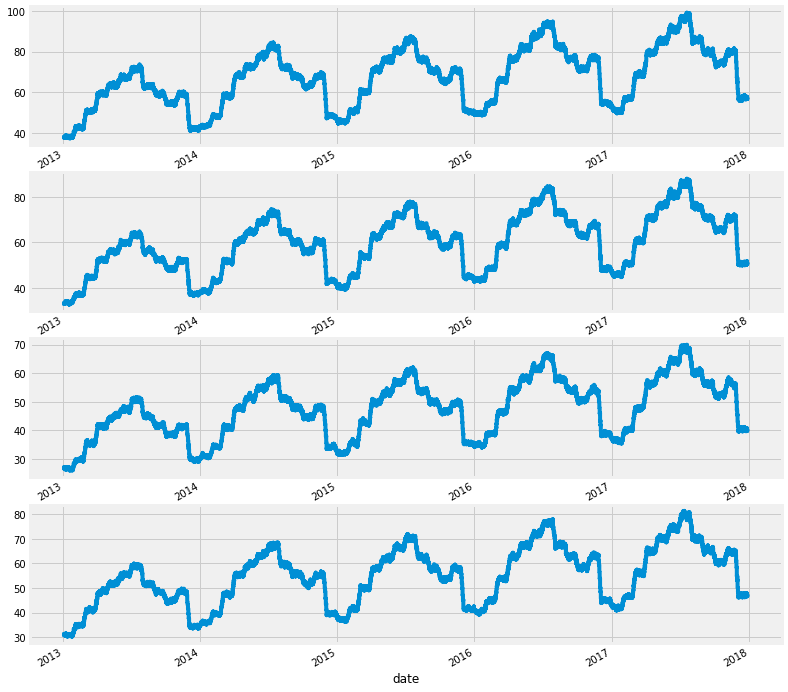

In [9]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize = (12,13))

# Seasonal decomposition of the sales dataset (method =  additive)

decomposition_a = seasonal_decompose(sales_a , model='additive' , freq = 365)
decomposition_a.trend.plot(ax = ax1)

decomposition_b = seasonal_decompose(sales_b , model='additive' , freq = 365)
decomposition_b.trend.plot(ax = ax2)

decomposition_c = seasonal_decompose(sales_c , model='additive' , freq = 365)
decomposition_c.trend.plot(ax = ax3)

decomposition_d = seasonal_decompose(sales_d , model='additive' , freq = 365)
decomposition_d.trend.plot(ax = ax4)

In [10]:
# Total Sales

date_sales = df_raw.drop(['store','item'],axis=1).copy()

In [11]:
y = date_sales['sales'].resample('MS').mean()
y['2017':]

date
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01    70.974933
2017-07-01    75.573742
2017-08-01    66.219548
2017-09-01    62.350867
2017-10-01    57.494194
2017-11-01    61.922467
2017-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

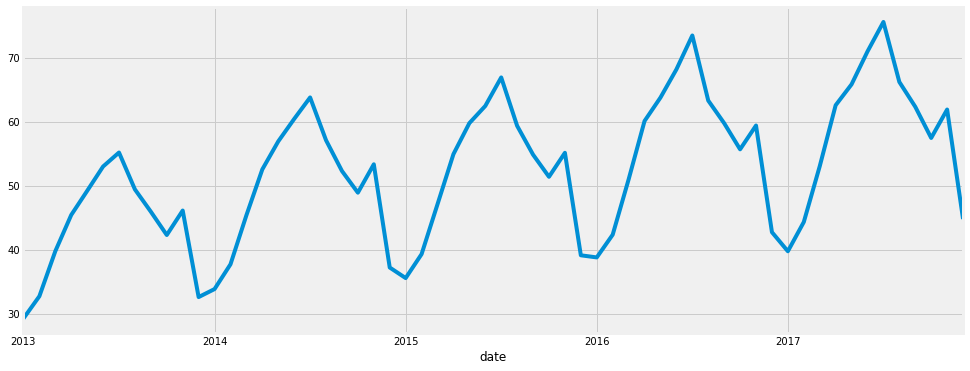

In [12]:
y.plot(figsize = (15,6))

<Figure size 432x288 with 0 Axes>

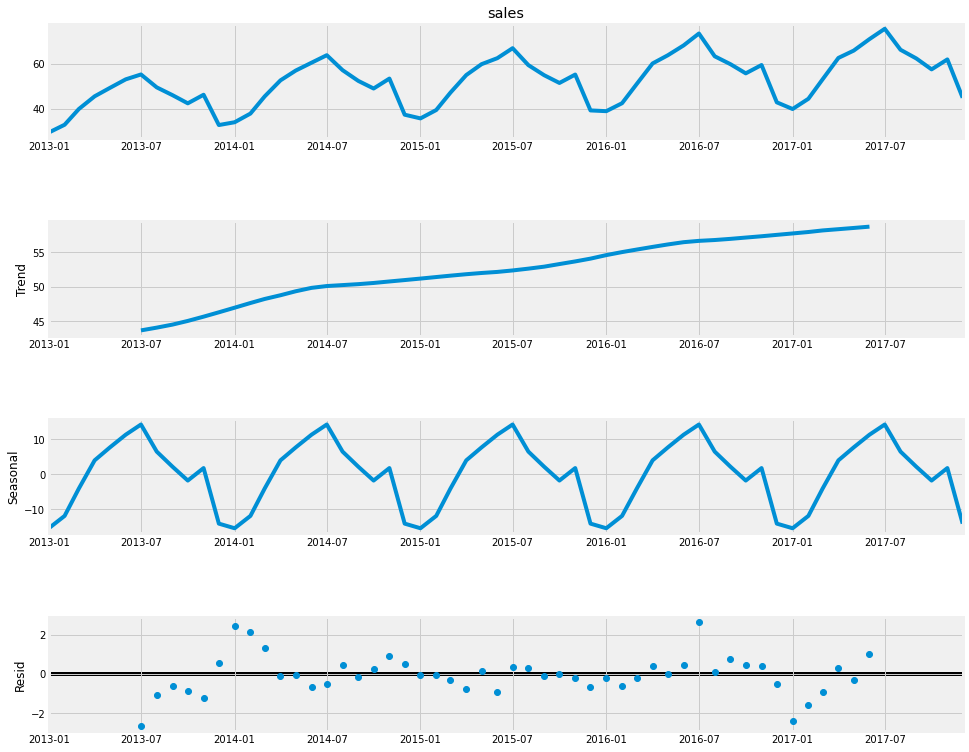

In [13]:
decomposition = seasonal_decompose(y , model='additive')

fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 12)

In [14]:
df_raw = df_raw.reset_index()
df_test = df_test.reset_index()

In [16]:
df_p = df_raw.copy()

In [17]:
#Fucntion to convert date column to date time attribute to plot pivot figures

import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_p,'date',False)


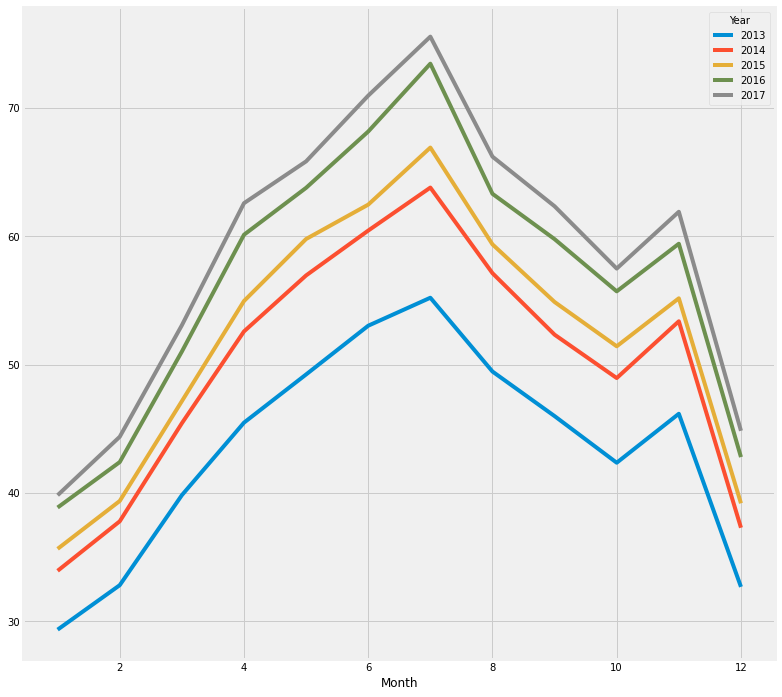

In [18]:
pivoted = pd.pivot_table(df_p, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

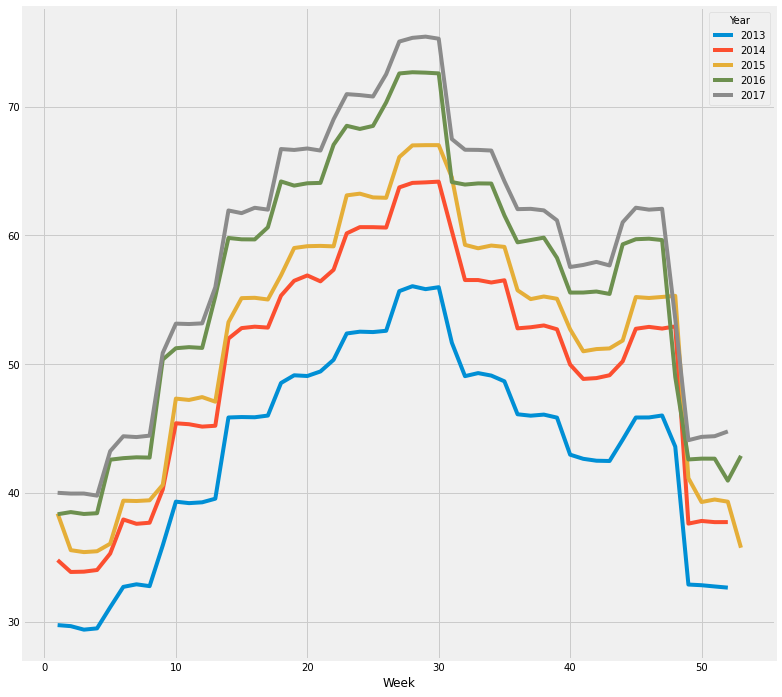

In [19]:
pivoted = pd.pivot_table(df_p, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

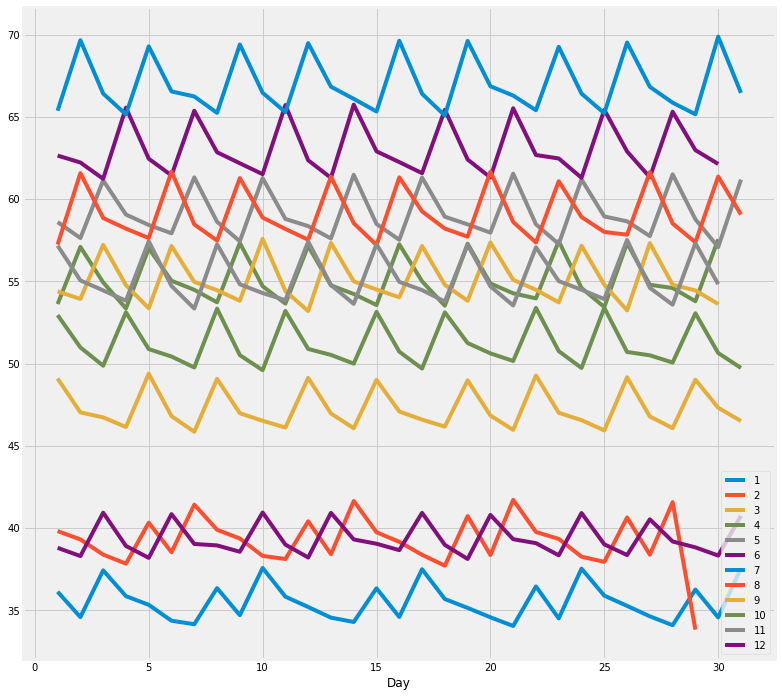

In [20]:
pivoted = pd.pivot_table(df_p, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12))
plt.legend(loc = 'lower right')

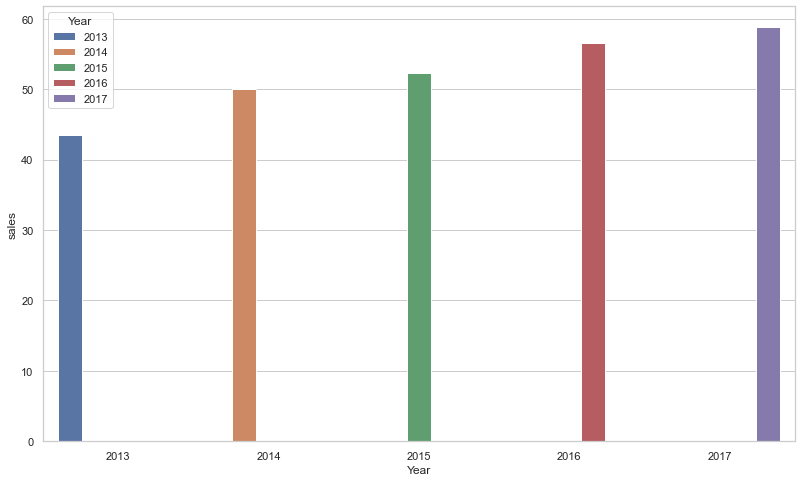

In [21]:
temp_1 = df_p.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.set(style="whitegrid")
sns.barplot('Year','sales',data = temp_1, hue='Year');

In [22]:
values = list(range(len(temp_1.Year)))
fig1 = go.Figure(go.Bar(x = temp_1.Year, y = temp_1.sales,marker_color = values ,text = temp_1.sales,textposition='auto'))
fig1.update_layout(title_text = 'Total sales by Year')
fig1.show()

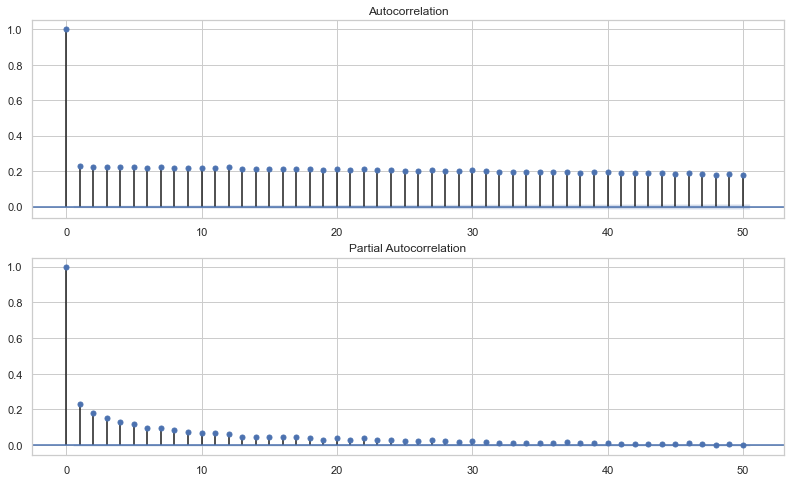

In [23]:
# figure for subplots
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
plt.subplot(211); plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(212); plot_pacf(sales_a, lags = 50, ax = plt.gca())
plt.show()

# SARIMA forecasting

In [24]:
# SARIMA forecasting

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
cnt = 0
h = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            h += [[param, param_seasonal, results.aic]]
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
                
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:639.3903169231555


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:515.5466998244792
Current Iter - 3, ARIMA(0, 0, 0)x(0, 0, 2, 12) 12 - AIC:348.42947156361873
Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:272.6904943205223


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 5, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:615.9110434928912
Current Iter - 6, ARIMA(0, 0, 0)x(0, 1, 2, 12) 12 - AIC:108.23584317340033
Current Iter - 7, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:182.9331890202681
Current Iter - 8, ARIMA(0, 0, 0)x(0, 2, 1, 12) 12 - AIC:91.65583596554843
Current Iter - 9, ARIMA(0, 0, 0)x(0, 2, 2, 12) 12 - AIC:29.959428810138682
Current Iter - 10, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:214.87722464483306
Current Iter - 11, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:194.20262112495914
Current Iter - 12, ARIMA(0, 0, 0)x(1, 0, 2, 12) 12 - AIC:98.36198198189379
Current Iter - 13, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:159.12960769423503


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 14, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:1518.9427925465948
Current Iter - 15, ARIMA(0, 0, 0)x(1, 1, 2, 12) 12 - AIC:92.0555436311475
Current Iter - 16, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:69.40423186123701
Current Iter - 17, ARIMA(0, 0, 0)x(1, 2, 1, 12) 12 - AIC:67.60786824977936
Current Iter - 18, ARIMA(0, 0, 0)x(1, 2, 2, 12) 12 - AIC:32.7428835191033
Current Iter - 19, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:100.56580160005478


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 20, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:96.77917966453893
Current Iter - 21, ARIMA(0, 0, 0)x(2, 0, 2, 12) 12 - AIC:97.39498600694537


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 22, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:49.39821838607184


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 23, ARIMA(0, 0, 0)x(2, 1, 1, 12) 12 - AIC:115.8424532646885
Current Iter - 24, ARIMA(0, 0, 0)x(2, 1, 2, 12) 12 - AIC:51.91362315462411
Current Iter - 25, ARIMA(0, 0, 0)x(2, 2, 0, 12) 12 - AIC:28.15258412980899
Current Iter - 26, ARIMA(0, 0, 0)x(2, 2, 1, 12) 12 - AIC:30.15255832858951
Current Iter - 27, ARIMA(0, 0, 0)x(2, 2, 2, 12) 12 - AIC:29.644648623033707
Current Iter - 28, ARIMA(0, 0, 1)x(0, 0, 0, 12) 12 - AIC:564.7029504460291


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 29, ARIMA(0, 0, 1)x(0, 0, 1, 12) 12 - AIC:454.891013231227
Current Iter - 30, ARIMA(0, 0, 1)x(0, 0, 2, 12) 12 - AIC:302.70181802107817
Current Iter - 31, ARIMA(0, 0, 1)x(0, 1, 0, 12) 12 - AIC:216.7307062243276


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 32, ARIMA(0, 0, 1)x(0, 1, 1, 12) 12 - AIC:1673.3128932268726
Current Iter - 33, ARIMA(0, 0, 1)x(0, 1, 2, 12) 12 - AIC:91.09232125348889
Current Iter - 34, ARIMA(0, 0, 1)x(0, 2, 0, 12) 12 - AIC:149.61098264370813
Current Iter - 35, ARIMA(0, 0, 1)x(0, 2, 1, 12) 12 - AIC:81.52118161266674
Current Iter - 36, ARIMA(0, 0, 1)x(0, 2, 2, 12) 12 - AIC:27.843917593906298


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 37, ARIMA(0, 0, 1)x(1, 0, 0, 12) 12 - AIC:217.7721092900985
Current Iter - 38, ARIMA(0, 0, 1)x(1, 0, 1, 12) 12 - AIC:164.46473164168998
Current Iter - 39, ARIMA(0, 0, 1)x(1, 0, 2, 12) 12 - AIC:95.7835942509468
Current Iter - 40, ARIMA(0, 0, 1)x(1, 1, 0, 12) 12 - AIC:134.5771866571545


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 41, ARIMA(0, 0, 1)x(1, 1, 1, 12) 12 - AIC:1534.944690055541
Current Iter - 42, ARIMA(0, 0, 1)x(1, 1, 2, 12) 12 - AIC:81.01592081287484
Current Iter - 43, ARIMA(0, 0, 1)x(1, 2, 0, 12) 12 - AIC:70.14181841982384
Current Iter - 44, ARIMA(0, 0, 1)x(1, 2, 1, 12) 12 - AIC:67.1423309381239
Current Iter - 45, ARIMA(0, 0, 1)x(1, 2, 2, 12) 12 - AIC:31.401555075132112


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 46, ARIMA(0, 0, 1)x(2, 0, 0, 12) 12 - AIC:103.33251793884877


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 47, ARIMA(0, 0, 1)x(2, 0, 1, 12) 12 - AIC:99.22849981864015


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 48, ARIMA(0, 0, 1)x(2, 0, 2, 12) 12 - AIC:91.07920510926094
Current Iter - 49, ARIMA(0, 0, 1)x(2, 1, 0, 12) 12 - AIC:31.190129853356318


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 51, ARIMA(0, 0, 1)x(2, 1, 2, 12) 12 - AIC:33.47031953603569
Current Iter - 52, ARIMA(0, 0, 1)x(2, 2, 0, 12) 12 - AIC:21.203495660540042
Current Iter - 53, ARIMA(0, 0, 1)x(2, 2, 1, 12) 12 - AIC:22.147389932449656
Current Iter - 54, ARIMA(0, 0, 1)x(2, 2, 2, 12) 12 - AIC:21.332485502021544
Current Iter - 55, ARIMA(0, 0, 2)x(0, 0, 0, 12) 12 - AIC:497.08131071874044
Current Iter - 56, ARIMA(0, 0, 2)x(0, 0, 1, 12) 12 - AIC:367.1436497137044
Current Iter - 57, ARIMA(0, 0, 2)x(0, 0, 2, 12) 12 - AIC:266.0219011922178
Current Iter - 58, ARIMA(0, 0, 2)x(0, 1, 0, 12) 12 - AIC:191.7333592262329


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 59, ARIMA(0, 0, 2)x(0, 1, 1, 12) 12 - AIC:1249.13086141898
Current Iter - 60, ARIMA(0, 0, 2)x(0, 1, 2, 12) 12 - AIC:87.87180230836368
Current Iter - 61, ARIMA(0, 0, 2)x(0, 2, 0, 12) 12 - AIC:140.166847562998
Current Iter - 62, ARIMA(0, 0, 2)x(0, 2, 1, 12) 12 - AIC:80.01254732716471
Current Iter - 63, ARIMA(0, 0, 2)x(0, 2, 2, 12) 12 - AIC:23.885363260937282
Current Iter - 64, ARIMA(0, 0, 2)x(1, 0, 0, 12) 12 - AIC:170.4795172728101


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 65, ARIMA(0, 0, 2)x(1, 0, 1, 12) 12 - AIC:166.6112161393502


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 66, ARIMA(0, 0, 2)x(1, 0, 2, 12) 12 - AIC:93.43203040035485
Current Iter - 67, ARIMA(0, 0, 2)x(1, 1, 0, 12) 12 - AIC:131.91565568773945


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 68, ARIMA(0, 0, 2)x(1, 1, 1, 12) 12 - AIC:1114.8906660611647
Current Iter - 69, ARIMA(0, 0, 2)x(1, 1, 2, 12) 12 - AIC:77.83759238561805
Current Iter - 70, ARIMA(0, 0, 2)x(1, 2, 0, 12) 12 - AIC:67.10905342580787
Current Iter - 71, ARIMA(0, 0, 2)x(1, 2, 1, 12) 12 - AIC:59.646396163721136
Current Iter - 72, ARIMA(0, 0, 2)x(1, 2, 2, 12) 12 - AIC:23.70153440524657
Current Iter - 73, ARIMA(0, 0, 2)x(2, 0, 0, 12) 12 - AIC:91.03229991378248


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 74, ARIMA(0, 0, 2)x(2, 0, 1, 12) 12 - AIC:94.90699847397876


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 75, ARIMA(0, 0, 2)x(2, 0, 2, 12) 12 - AIC:89.61359412837282
Current Iter - 76, ARIMA(0, 0, 2)x(2, 1, 0, 12) 12 - AIC:27.896627299804145


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 77, ARIMA(0, 0, 2)x(2, 1, 1, 12) 12 - AIC:820.6050477924599


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 78, ARIMA(0, 0, 2)x(2, 1, 2, 12) 12 - AIC:29.165965148946874


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 79, ARIMA(0, 0, 2)x(2, 2, 0, 12) 12 - AIC:18.221791498406443
Current Iter - 80, ARIMA(0, 0, 2)x(2, 2, 1, 12) 12 - AIC:20.659928186070925


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 81, ARIMA(0, 0, 2)x(2, 2, 2, 12) 12 - AIC:14.062701760731212
Current Iter - 82, ARIMA(0, 1, 0)x(0, 0, 0, 12) 12 - AIC:391.16370596944984
Current Iter - 83, ARIMA(0, 1, 0)x(0, 0, 1, 12) 12 - AIC:280.01693382101456
Current Iter - 84, ARIMA(0, 1, 0)x(0, 0, 2, 12) 12 - AIC:199.49196405467262
Current Iter - 85, ARIMA(0, 1, 0)x(0, 1, 0, 12) 12 - AIC:141.2800167821235


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 86, ARIMA(0, 1, 0)x(0, 1, 1, 12) 12 - AIC:1574.4635031840085
Current Iter - 87, ARIMA(0, 1, 0)x(0, 1, 2, 12) 12 - AIC:69.38171920694174
Current Iter - 88, ARIMA(0, 1, 0)x(0, 2, 0, 12) 12 - AIC:128.31982721171488
Current Iter - 89, ARIMA(0, 1, 0)x(0, 2, 1, 12) 12 - AIC:72.59011109162209
Current Iter - 90, ARIMA(0, 1, 0)x(0, 2, 2, 12) 12 - AIC:34.70372790797831
Current Iter - 91, ARIMA(0, 1, 0)x(1, 0, 0, 12) 12 - AIC:138.60023667081214
Current Iter - 92, ARIMA(0, 1, 0)x(1, 0, 1, 12) 12 - AIC:135.91966764653458
Current Iter - 93, ARIMA(0, 1, 0)x(1, 0, 2, 12) 12 - AIC:96.14447417233929
Current Iter - 94, ARIMA(0, 1, 0)x(1, 1, 0, 12) 12 - AIC:101.09291937376581


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 95, ARIMA(0, 1, 0)x(1, 1, 1, 12) 12 - AIC:124.70468645028832
Current Iter - 96, ARIMA(0, 1, 0)x(1, 1, 2, 12) 12 - AIC:71.2934702494282
Current Iter - 97, ARIMA(0, 1, 0)x(1, 2, 0, 12) 12 - AIC:75.20416915953999
Current Iter - 98, ARIMA(0, 1, 0)x(1, 2, 1, 12) 12 - AIC:74.24263115291
Current Iter - 99, ARIMA(0, 1, 0)x(1, 2, 2, 12) 12 - AIC:36.87730387685563
Current Iter - 101, ARIMA(0, 1, 0)x(2, 0, 1, 12) 12 - AIC:99.3064707187561
Current Iter - 102, ARIMA(0, 1, 0)x(2, 0, 2, 12) 12 - AIC:95.35524268330366
Current Iter - 103, ARIMA(0, 1, 0)x(2, 1, 0, 12) 12 - AIC:71.91438761329444


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 104, ARIMA(0, 1, 0)x(2, 1, 1, 12) 12 - AIC:533.5992282458271
Current Iter - 105, ARIMA(0, 1, 0)x(2, 1, 2, 12) 12 - AIC:73.90149482542
Current Iter - 106, ARIMA(0, 1, 0)x(2, 2, 0, 12) 12 - AIC:37.536785270677036
Current Iter - 107, ARIMA(0, 1, 0)x(2, 2, 1, 12) 12 - AIC:39.83693294176006


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 108, ARIMA(0, 1, 0)x(2, 2, 2, 12) 12 - AIC:38.87248946488105
Current Iter - 109, ARIMA(0, 1, 1)x(0, 0, 0, 12) 12 - AIC:384.96710604512566
Current Iter - 110, ARIMA(0, 1, 1)x(0, 0, 1, 12) 12 - AIC:274.23957714564125
Current Iter - 111, ARIMA(0, 1, 1)x(0, 0, 2, 12) 12 - AIC:194.43784063485947
Current Iter - 112, ARIMA(0, 1, 1)x(0, 1, 0, 12) 12 - AIC:140.6110365466007


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 113, ARIMA(0, 1, 1)x(0, 1, 1, 12) 12 - AIC:483.79631331638893
Current Iter - 114, ARIMA(0, 1, 1)x(0, 1, 2, 12) 12 - AIC:66.76843412934127
Current Iter - 115, ARIMA(0, 1, 1)x(0, 2, 0, 12) 12 - AIC:126.80753401276598
Current Iter - 116, ARIMA(0, 1, 1)x(0, 2, 1, 12) 12 - AIC:62.31307008085504
Current Iter - 117, ARIMA(0, 1, 1)x(0, 2, 2, 12) 12 - AIC:26.64953917202734
Current Iter - 118, ARIMA(0, 1, 1)x(1, 0, 0, 12) 12 - AIC:138.93500779369623


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 119, ARIMA(0, 1, 1)x(1, 0, 1, 12) 12 - AIC:137.5814044652044
Current Iter - 120, ARIMA(0, 1, 1)x(1, 0, 2, 12) 12 - AIC:88.51797806208036
Current Iter - 121, ARIMA(0, 1, 1)x(1, 1, 0, 12) 12 - AIC:98.18501105125397


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 122, ARIMA(0, 1, 1)x(1, 1, 1, 12) 12 - AIC:726.26793626057
Current Iter - 123, ARIMA(0, 1, 1)x(1, 1, 2, 12) 12 - AIC:68.61003730781249
Current Iter - 124, ARIMA(0, 1, 1)x(1, 2, 0, 12) 12 - AIC:55.31148474170416
Current Iter - 125, ARIMA(0, 1, 1)x(1, 2, 1, 12) 12 - AIC:53.60262098157287
Current Iter - 126, ARIMA(0, 1, 1)x(1, 2, 2, 12) 12 - AIC:27.744066595134115
Current Iter - 127, ARIMA(0, 1, 1)x(2, 0, 0, 12) 12 - AIC:82.09625464988383
Current Iter - 128, ARIMA(0, 1, 1)x(2, 0, 1, 12) 12 - AIC:80.55076981888656


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 129, ARIMA(0, 1, 1)x(2, 0, 2, 12) 12 - AIC:80.25307254499432
Current Iter - 130, ARIMA(0, 1, 1)x(2, 1, 0, 12) 12 - AIC:52.657693822996734


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 131, ARIMA(0, 1, 1)x(2, 1, 1, 12) 12 - AIC:1107.3995183379316
Current Iter - 132, ARIMA(0, 1, 1)x(2, 1, 2, 12) 12 - AIC:53.413615963526965
Current Iter - 133, ARIMA(0, 1, 1)x(2, 2, 0, 12) 12 - AIC:30.217703187551546
Current Iter - 134, ARIMA(0, 1, 1)x(2, 2, 1, 12) 12 - AIC:31.24780969949278
Current Iter - 135, ARIMA(0, 1, 1)x(2, 2, 2, 12) 12 - AIC:29.74408205234118
Current Iter - 136, ARIMA(0, 1, 2)x(0, 0, 0, 12) 12 - AIC:379.497114230056
Current Iter - 137, ARIMA(0, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.3789538004247
Current Iter - 138, ARIMA(0, 1, 2)x(0, 0, 2, 12) 12 - AIC:191.0125886534712
Current Iter - 139, ARIMA(0, 1, 2)x(0, 1, 0, 12) 12 - AIC:138.44971994795844


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 140, ARIMA(0, 1, 2)x(0, 1, 1, 12) 12 - AIC:587.857792196081
Current Iter - 141, ARIMA(0, 1, 2)x(0, 1, 2, 12) 12 - AIC:64.2635048922819
Current Iter - 142, ARIMA(0, 1, 2)x(0, 2, 0, 12) 12 - AIC:125.41271824784843
Current Iter - 143, ARIMA(0, 1, 2)x(0, 2, 1, 12) 12 - AIC:56.743192950207735
Current Iter - 144, ARIMA(0, 1, 2)x(0, 2, 2, 12) 12 - AIC:23.41206717406866
Current Iter - 145, ARIMA(0, 1, 2)x(1, 0, 0, 12) 12 - AIC:140.83543214806335


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 146, ARIMA(0, 1, 2)x(1, 0, 1, 12) 12 - AIC:136.27564818395166


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 147, ARIMA(0, 1, 2)x(1, 0, 2, 12) 12 - AIC:79.92991243707931
Current Iter - 148, ARIMA(0, 1, 2)x(1, 1, 0, 12) 12 - AIC:99.1515122761607


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 149, ARIMA(0, 1, 2)x(1, 1, 1, 12) 12 - AIC:570.3045117427508
Current Iter - 151, ARIMA(0, 1, 2)x(1, 2, 0, 12) 12 - AIC:46.8662474752956
Current Iter - 152, ARIMA(0, 1, 2)x(1, 2, 1, 12) 12 - AIC:43.684997472072205
Current Iter - 153, ARIMA(0, 1, 2)x(1, 2, 2, 12) 12 - AIC:20.923640848842616
Current Iter - 154, ARIMA(0, 1, 2)x(2, 0, 0, 12) 12 - AIC:64.68355023722131


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 155, ARIMA(0, 1, 2)x(2, 0, 1, 12) 12 - AIC:67.10003183465747


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 156, ARIMA(0, 1, 2)x(2, 0, 2, 12) 12 - AIC:65.04965937279977
Current Iter - 157, ARIMA(0, 1, 2)x(2, 1, 0, 12) 12 - AIC:39.76375885348851


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 158, ARIMA(0, 1, 2)x(2, 1, 1, 12) 12 - AIC:459.29247480457633
Current Iter - 159, ARIMA(0, 1, 2)x(2, 1, 2, 12) 12 - AIC:37.982352836380585
Current Iter - 160, ARIMA(0, 1, 2)x(2, 2, 0, 12) 12 - AIC:28.561726858217884
Current Iter - 161, ARIMA(0, 1, 2)x(2, 2, 1, 12) 12 - AIC:30.259253133633514


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 162, ARIMA(0, 1, 2)x(2, 2, 2, 12) 12 - AIC:21.807559776023858
Current Iter - 163, ARIMA(0, 2, 0)x(0, 0, 0, 12) 12 - AIC:409.9633450626792
Current Iter - 164, ARIMA(0, 2, 0)x(0, 0, 1, 12) 12 - AIC:294.0410142776749
Current Iter - 165, ARIMA(0, 2, 0)x(0, 0, 2, 12) 12 - AIC:208.69915379437649
Current Iter - 166, ARIMA(0, 2, 0)x(0, 1, 0, 12) 12 - AIC:173.579908848212


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 167, ARIMA(0, 2, 0)x(0, 1, 1, 12) 12 - AIC:1196.9313047022458
Current Iter - 168, ARIMA(0, 2, 0)x(0, 1, 2, 12) 12 - AIC:91.62752768342807
Current Iter - 169, ARIMA(0, 2, 0)x(0, 2, 0, 12) 12 - AIC:152.34774333660064
Current Iter - 170, ARIMA(0, 2, 0)x(0, 2, 1, 12) 12 - AIC:94.29496400036311
Current Iter - 171, ARIMA(0, 2, 0)x(0, 2, 2, 12) 12 - AIC:42.53139122762766
Current Iter - 172, ARIMA(0, 2, 0)x(1, 0, 0, 12) 12 - AIC:175.79994679513385
Current Iter - 173, ARIMA(0, 2, 0)x(1, 0, 1, 12) 12 - AIC:174.3017486907947
Current Iter - 174, ARIMA(0, 2, 0)x(1, 0, 2, 12) 12 - AIC:133.08679907679922
Current Iter - 175, ARIMA(0, 2, 0)x(1, 1, 0, 12) 12 - AIC:133.3927809920983


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 176, ARIMA(0, 2, 0)x(1, 1, 1, 12) 12 - AIC:721.9326702745509
Current Iter - 177, ARIMA(0, 2, 0)x(1, 1, 2, 12) 12 - AIC:89.24289804611236
Current Iter - 178, ARIMA(0, 2, 0)x(1, 2, 0, 12) 12 - AIC:99.04557020046322
Current Iter - 179, ARIMA(0, 2, 0)x(1, 2, 1, 12) 12 - AIC:97.05711294358751
Current Iter - 180, ARIMA(0, 2, 0)x(1, 2, 2, 12) 12 - AIC:45.5584627314945
Current Iter - 181, ARIMA(0, 2, 0)x(2, 0, 0, 12) 12 - AIC:134.18760698159252
Current Iter - 182, ARIMA(0, 2, 0)x(2, 0, 1, 12) 12 - AIC:135.87491618891642
Current Iter - 183, ARIMA(0, 2, 0)x(2, 0, 2, 12) 12 - AIC:130.37293403811367
Current Iter - 184, ARIMA(0, 2, 0)x(2, 1, 0, 12) 12 - AIC:94.78896067265393


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 185, ARIMA(0, 2, 0)x(2, 1, 1, 12) 12 - AIC:873.5524442308791
Current Iter - 186, ARIMA(0, 2, 0)x(2, 1, 2, 12) 12 - AIC:95.42307714084883
Current Iter - 187, ARIMA(0, 2, 0)x(2, 2, 0, 12) 12 - AIC:45.72981461630523
Current Iter - 188, ARIMA(0, 2, 0)x(2, 2, 1, 12) 12 - AIC:47.72984033048441
Current Iter - 189, ARIMA(0, 2, 0)x(2, 2, 2, 12) 12 - AIC:46.12381503332914
Current Iter - 190, ARIMA(0, 2, 1)x(0, 0, 0, 12) 12 - AIC:384.7192729651891
Current Iter - 191, ARIMA(0, 2, 1)x(0, 0, 1, 12) 12 - AIC:273.7991740997491
Current Iter - 192, ARIMA(0, 2, 1)x(0, 0, 2, 12) 12 - AIC:192.86969240052053
Current Iter - 193, ARIMA(0, 2, 1)x(0, 1, 0, 12) 12 - AIC:141.402252076849


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 194, ARIMA(0, 2, 1)x(0, 1, 1, 12) 12 - AIC:1008.1338948371388
Current Iter - 195, ARIMA(0, 2, 1)x(0, 1, 2, 12) 12 - AIC:67.2997561680461
Current Iter - 196, ARIMA(0, 2, 1)x(0, 2, 0, 12) 12 - AIC:127.34049966143832
Current Iter - 197, ARIMA(0, 2, 1)x(0, 2, 1, 12) 12 - AIC:72.20069448622746
Current Iter - 198, ARIMA(0, 2, 1)x(0, 2, 2, 12) 12 - AIC:32.79941284390916
Current Iter - 199, ARIMA(0, 2, 1)x(1, 0, 0, 12) 12 - AIC:142.34823907854297


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 201, ARIMA(0, 2, 1)x(1, 0, 2, 12) 12 - AIC:97.4253648209708
Current Iter - 202, ARIMA(0, 2, 1)x(1, 1, 0, 12) 12 - AIC:104.88137078719998


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 203, ARIMA(0, 2, 1)x(1, 1, 1, 12) 12 - AIC:1010.0334590035663
Current Iter - 204, ARIMA(0, 2, 1)x(1, 1, 2, 12) 12 - AIC:69.29314454306314
Current Iter - 205, ARIMA(0, 2, 1)x(1, 2, 0, 12) 12 - AIC:78.22156635602164
Current Iter - 206, ARIMA(0, 2, 1)x(1, 2, 1, 12) 12 - AIC:74.09761645767371
Current Iter - 207, ARIMA(0, 2, 1)x(1, 2, 2, 12) 12 - AIC:35.32027737469987
Current Iter - 208, ARIMA(0, 2, 1)x(2, 0, 0, 12) 12 - AIC:101.66087309928014
Current Iter - 209, ARIMA(0, 2, 1)x(2, 0, 1, 12) 12 - AIC:102.84085594158401


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 210, ARIMA(0, 2, 1)x(2, 0, 2, 12) 12 - AIC:96.68263115690593
Current Iter - 211, ARIMA(0, 2, 1)x(2, 1, 0, 12) 12 - AIC:75.16175393585613


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 212, ARIMA(0, 2, 1)x(2, 1, 1, 12) 12 - AIC:665.4310271479285


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 213, ARIMA(0, 2, 1)x(2, 1, 2, 12) 12 - AIC:73.74834320574105
Current Iter - 214, ARIMA(0, 2, 1)x(2, 2, 0, 12) 12 - AIC:39.95214944478799
Current Iter - 215, ARIMA(0, 2, 1)x(2, 2, 1, 12) 12 - AIC:39.74433289294612
Current Iter - 216, ARIMA(0, 2, 1)x(2, 2, 2, 12) 12 - AIC:37.55805828432109
Current Iter - 217, ARIMA(0, 2, 2)x(0, 0, 0, 12) 12 - AIC:379.2976443382623
Current Iter - 218, ARIMA(0, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.3971077690178
Current Iter - 219, ARIMA(0, 2, 2)x(0, 0, 2, 12) 12 - AIC:189.49380602254152
Current Iter - 220, ARIMA(0, 2, 2)x(0, 1, 0, 12) 12 - AIC:140.78824507076342


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 221, ARIMA(0, 2, 2)x(0, 1, 1, 12) 12 - AIC:1215.0490608019195
Current Iter - 222, ARIMA(0, 2, 2)x(0, 1, 2, 12) 12 - AIC:64.26297822039737
Current Iter - 223, ARIMA(0, 2, 2)x(0, 2, 0, 12) 12 - AIC:125.66523555614577
Current Iter - 224, ARIMA(0, 2, 2)x(0, 2, 1, 12) 12 - AIC:57.31767273047373
Current Iter - 225, ARIMA(0, 2, 2)x(0, 2, 2, 12) 12 - AIC:25.781060645689383
Current Iter - 226, ARIMA(0, 2, 2)x(1, 0, 0, 12) 12 - AIC:142.92990799946782


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 227, ARIMA(0, 2, 2)x(1, 0, 1, 12) 12 - AIC:137.91862617143892


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 228, ARIMA(0, 2, 2)x(1, 0, 2, 12) 12 - AIC:84.18911773574126
Current Iter - 229, ARIMA(0, 2, 2)x(1, 1, 0, 12) 12 - AIC:102.85587703706942


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 230, ARIMA(0, 2, 2)x(1, 1, 1, 12) 12 - AIC:1217.015893256226
Current Iter - 231, ARIMA(0, 2, 2)x(1, 1, 2, 12) 12 - AIC:49.80527929017544
Current Iter - 232, ARIMA(0, 2, 2)x(1, 2, 0, 12) 12 - AIC:62.117808585075565
Current Iter - 233, ARIMA(0, 2, 2)x(1, 2, 1, 12) 12 - AIC:55.97771046153093
Current Iter - 234, ARIMA(0, 2, 2)x(1, 2, 2, 12) 12 - AIC:26.11858471765465
Current Iter - 235, ARIMA(0, 2, 2)x(2, 0, 0, 12) 12 - AIC:87.37529221123872
Current Iter - 236, ARIMA(0, 2, 2)x(2, 0, 1, 12) 12 - AIC:84.17001777612013


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 237, ARIMA(0, 2, 2)x(2, 0, 2, 12) 12 - AIC:77.93547465332304
Current Iter - 238, ARIMA(0, 2, 2)x(2, 1, 0, 12) 12 - AIC:59.50130454466751


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 239, ARIMA(0, 2, 2)x(2, 1, 1, 12) 12 - AIC:835.0386743359013
Current Iter - 240, ARIMA(0, 2, 2)x(2, 1, 2, 12) 12 - AIC:69.47383829724423
Current Iter - 241, ARIMA(0, 2, 2)x(2, 2, 0, 12) 12 - AIC:29.887567615680886
Current Iter - 242, ARIMA(0, 2, 2)x(2, 2, 1, 12) 12 - AIC:33.7128951590181
Current Iter - 243, ARIMA(0, 2, 2)x(2, 2, 2, 12) 12 - AIC:28.118561697617263
Current Iter - 244, ARIMA(1, 0, 0)x(0, 0, 0, 12) 12 - AIC:399.033976504337
Current Iter - 245, ARIMA(1, 0, 0)x(0, 0, 1, 12) 12 - AIC:322.8735511616172
Current Iter - 246, ARIMA(1, 0, 0)x(0, 0, 2, 12) 12 - AIC:207.13223616594405
Current Iter - 247, ARIMA(1, 0, 0)x(0, 1, 0, 12) 12 - AIC:144.16169983608683


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 248, ARIMA(1, 0, 0)x(0, 1, 1, 12) 12 - AIC:1042.4438665180724
Current Iter - 249, ARIMA(1, 0, 0)x(0, 1, 2, 12) 12 - AIC:72.98244924301737
Current Iter - 251, ARIMA(1, 0, 0)x(0, 2, 1, 12) 12 - AIC:74.0632990887705
Current Iter - 252, ARIMA(1, 0, 0)x(0, 2, 2, 12) 12 - AIC:28.435413412537457
Current Iter - 253, ARIMA(1, 0, 0)x(1, 0, 0, 12) 12 - AIC:137.37426447662443
Current Iter - 254, ARIMA(1, 0, 0)x(1, 0, 1, 12) 12 - AIC:136.194306484324
Current Iter - 255, ARIMA(1, 0, 0)x(1, 0, 2, 12) 12 - AIC:95.06894141716592
Current Iter - 256, ARIMA(1, 0, 0)x(1, 1, 0, 12) 12 - AIC:102.41329405900125


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 257, ARIMA(1, 0, 0)x(1, 1, 1, 12) 12 - AIC:899.9095238067939
Current Iter - 258, ARIMA(1, 0, 0)x(1, 1, 2, 12) 12 - AIC:74.76790368968128
Current Iter - 259, ARIMA(1, 0, 0)x(1, 2, 0, 12) 12 - AIC:67.50428084467687
Current Iter - 260, ARIMA(1, 0, 0)x(1, 2, 1, 12) 12 - AIC:69.2960824784575


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 261, ARIMA(1, 0, 0)x(1, 2, 2, 12) 12 - AIC:24.24615712350777
Current Iter - 262, ARIMA(1, 0, 0)x(2, 0, 0, 12) 12 - AIC:90.33603721787472
Current Iter - 263, ARIMA(1, 0, 0)x(2, 0, 1, 12) 12 - AIC:92.33603971428393


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 264, ARIMA(1, 0, 0)x(2, 0, 2, 12) 12 - AIC:89.7438131492172
Current Iter - 265, ARIMA(1, 0, 0)x(2, 1, 0, 12) 12 - AIC:41.721048887700775


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 266, ARIMA(1, 0, 0)x(2, 1, 1, 12) 12 - AIC:687.0530485669976
Current Iter - 267, ARIMA(1, 0, 0)x(2, 1, 2, 12) 12 - AIC:44.89920891187175
Current Iter - 268, ARIMA(1, 0, 0)x(2, 2, 0, 12) 12 - AIC:22.22538329367878
Current Iter - 269, ARIMA(1, 0, 0)x(2, 2, 1, 12) 12 - AIC:24.224953411513237
Current Iter - 270, ARIMA(1, 0, 0)x(2, 2, 2, 12) 12 - AIC:26.21992106411875
Current Iter - 271, ARIMA(1, 0, 1)x(0, 0, 0, 12) 12 - AIC:393.51189955812816
Current Iter - 272, ARIMA(1, 0, 1)x(0, 0, 1, 12) 12 - AIC:317.470959372565
Current Iter - 273, ARIMA(1, 0, 1)x(0, 0, 2, 12) 12 - AIC:203.58681325207326
Current Iter - 274, ARIMA(1, 0, 1)x(0, 1, 0, 12) 12 - AIC:143.70107617504573


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 275, ARIMA(1, 0, 1)x(0, 1, 1, 12) 12 - AIC:1217.8075991200944
Current Iter - 276, ARIMA(1, 0, 1)x(0, 1, 2, 12) 12 - AIC:71.14615738851359
Current Iter - 277, ARIMA(1, 0, 1)x(0, 2, 0, 12) 12 - AIC:129.63606808736137
Current Iter - 278, ARIMA(1, 0, 1)x(0, 2, 1, 12) 12 - AIC:67.69419272232011
Current Iter - 279, ARIMA(1, 0, 1)x(0, 2, 2, 12) 12 - AIC:31.22212553914924
Current Iter - 280, ARIMA(1, 0, 1)x(1, 0, 0, 12) 12 - AIC:138.3950219616782


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 281, ARIMA(1, 0, 1)x(1, 0, 1, 12) 12 - AIC:138.90343817677743
Current Iter - 282, ARIMA(1, 0, 1)x(1, 0, 2, 12) 12 - AIC:90.46500822183499
Current Iter - 283, ARIMA(1, 0, 1)x(1, 1, 0, 12) 12 - AIC:100.27210177864232


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 284, ARIMA(1, 0, 1)x(1, 1, 1, 12) 12 - AIC:1079.457500825272
Current Iter - 285, ARIMA(1, 0, 1)x(1, 1, 2, 12) 12 - AIC:72.93336437105039
Current Iter - 286, ARIMA(1, 0, 1)x(1, 2, 0, 12) 12 - AIC:57.158113604461164
Current Iter - 287, ARIMA(1, 0, 1)x(1, 2, 1, 12) 12 - AIC:57.000265840696905
Current Iter - 288, ARIMA(1, 0, 1)x(1, 2, 2, 12) 12 - AIC:29.56027835399182
Current Iter - 289, ARIMA(1, 0, 1)x(2, 0, 0, 12) 12 - AIC:82.77866899823827
Current Iter - 290, ARIMA(1, 0, 1)x(2, 0, 1, 12) 12 - AIC:81.37874038179064


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 291, ARIMA(1, 0, 1)x(2, 0, 2, 12) 12 - AIC:81.5008264853477
Current Iter - 292, ARIMA(1, 0, 1)x(2, 1, 0, 12) 12 - AIC:29.69326704913156


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 293, ARIMA(1, 0, 1)x(2, 1, 1, 12) 12 - AIC:740.2832642819151


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 294, ARIMA(1, 0, 1)x(2, 1, 2, 12) 12 - AIC:32.276263117772345
Current Iter - 295, ARIMA(1, 0, 1)x(2, 2, 0, 12) 12 - AIC:18.039384098299287


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 296, ARIMA(1, 0, 1)x(2, 2, 1, 12) 12 - AIC:19.87373610783394


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 297, ARIMA(1, 0, 1)x(2, 2, 2, 12) 12 - AIC:20.507704120511892
Current Iter - 298, ARIMA(1, 0, 2)x(0, 0, 0, 12) 12 - AIC:387.5084202891015
Current Iter - 299, ARIMA(1, 0, 2)x(0, 0, 1, 12) 12 - AIC:311.84174931934325
Current Iter - 301, ARIMA(1, 0, 2)x(0, 1, 0, 12) 12 - AIC:142.99015674302365


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 302, ARIMA(1, 0, 2)x(0, 1, 1, 12) 12 - AIC:1496.3108770396343
Current Iter - 303, ARIMA(1, 0, 2)x(0, 1, 2, 12) 12 - AIC:69.96185466468162
Current Iter - 304, ARIMA(1, 0, 2)x(0, 2, 0, 12) 12 - AIC:128.3859524648617
Current Iter - 305, ARIMA(1, 0, 2)x(0, 2, 1, 12) 12 - AIC:61.99799920551036


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 306, ARIMA(1, 0, 2)x(0, 2, 2, 12) 12 - AIC:22.92122576623761
Current Iter - 307, ARIMA(1, 0, 2)x(1, 0, 0, 12) 12 - AIC:140.27291518962798
Current Iter - 308, ARIMA(1, 0, 2)x(1, 0, 1, 12) 12 - AIC:133.07232149463124


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 309, ARIMA(1, 0, 2)x(1, 0, 2, 12) 12 - AIC:80.1809688049603
Current Iter - 310, ARIMA(1, 0, 2)x(1, 1, 0, 12) 12 - AIC:100.85600053269914


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 311, ARIMA(1, 0, 2)x(1, 1, 1, 12) 12 - AIC:1362.0697802765026
Current Iter - 312, ARIMA(1, 0, 2)x(1, 1, 2, 12) 12 - AIC:71.77710888930929
Current Iter - 313, ARIMA(1, 0, 2)x(1, 2, 0, 12) 12 - AIC:48.75113925237931
Current Iter - 314, ARIMA(1, 0, 2)x(1, 2, 1, 12) 12 - AIC:51.41726101064354
Current Iter - 315, ARIMA(1, 0, 2)x(1, 2, 2, 12) 12 - AIC:23.646895876189824
Current Iter - 316, ARIMA(1, 0, 2)x(2, 0, 0, 12) 12 - AIC:65.7283642935281
Current Iter - 317, ARIMA(1, 0, 2)x(2, 0, 1, 12) 12 - AIC:67.72141228457272


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 318, ARIMA(1, 0, 2)x(2, 0, 2, 12) 12 - AIC:67.48615197461524


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 319, ARIMA(1, 0, 2)x(2, 1, 0, 12) 12 - AIC:27.949992792988606


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 320, ARIMA(1, 0, 2)x(2, 1, 1, 12) 12 - AIC:959.795964524748
Current Iter - 321, ARIMA(1, 0, 2)x(2, 1, 2, 12) 12 - AIC:30.613330276768746


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 322, ARIMA(1, 0, 2)x(2, 2, 0, 12) 12 - AIC:17.558395897276693
Current Iter - 323, ARIMA(1, 0, 2)x(2, 2, 1, 12) 12 - AIC:30.491788812249276


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 324, ARIMA(1, 0, 2)x(2, 2, 2, 12) 12 - AIC:21.992316640787248
Current Iter - 325, ARIMA(1, 1, 0)x(0, 0, 0, 12) 12 - AIC:391.0641614052094
Current Iter - 326, ARIMA(1, 1, 0)x(0, 0, 1, 12) 12 - AIC:280.0900946882173
Current Iter - 327, ARIMA(1, 1, 0)x(0, 0, 2, 12) 12 - AIC:200.437055687893
Current Iter - 328, ARIMA(1, 1, 0)x(0, 1, 0, 12) 12 - AIC:143.0318404147252


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 329, ARIMA(1, 1, 0)x(0, 1, 1, 12) 12 - AIC:714.4565052456771
Current Iter - 330, ARIMA(1, 1, 0)x(0, 1, 2, 12) 12 - AIC:69.11971289926475
Current Iter - 331, ARIMA(1, 1, 0)x(0, 2, 0, 12) 12 - AIC:129.79841558684768
Current Iter - 332, ARIMA(1, 1, 0)x(0, 2, 1, 12) 12 - AIC:66.22317784609956
Current Iter - 333, ARIMA(1, 1, 0)x(0, 2, 2, 12) 12 - AIC:32.05274017716143
Current Iter - 334, ARIMA(1, 1, 0)x(1, 0, 0, 12) 12 - AIC:137.12786861275382


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 335, ARIMA(1, 1, 0)x(1, 0, 1, 12) 12 - AIC:139.55644491538783


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 336, ARIMA(1, 1, 0)x(1, 0, 2, 12) 12 - AIC:91.13236633889021
Current Iter - 337, ARIMA(1, 1, 0)x(1, 1, 0, 12) 12 - AIC:96.2995037745511


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 338, ARIMA(1, 1, 0)x(1, 1, 1, 12) 12 - AIC:731.9064237060495
Current Iter - 339, ARIMA(1, 1, 0)x(1, 1, 2, 12) 12 - AIC:71.11903517562328
Current Iter - 340, ARIMA(1, 1, 0)x(1, 2, 0, 12) 12 - AIC:63.611885386878654
Current Iter - 341, ARIMA(1, 1, 0)x(1, 2, 1, 12) 12 - AIC:64.62912029021231


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 342, ARIMA(1, 1, 0)x(1, 2, 2, 12) 12 - AIC:32.93303615670801
Current Iter - 343, ARIMA(1, 1, 0)x(2, 0, 0, 12) 12 - AIC:83.0250160710998
Current Iter - 344, ARIMA(1, 1, 0)x(2, 0, 1, 12) 12 - AIC:83.79982935514332


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 345, ARIMA(1, 1, 0)x(2, 0, 2, 12) 12 - AIC:82.93528955211134
Current Iter - 346, ARIMA(1, 1, 0)x(2, 1, 0, 12) 12 - AIC:60.48106827002565


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 347, ARIMA(1, 1, 0)x(2, 1, 1, 12) 12 - AIC:589.9386847415524
Current Iter - 348, ARIMA(1, 1, 0)x(2, 1, 2, 12) 12 - AIC:64.37937922331093
Current Iter - 349, ARIMA(1, 1, 0)x(2, 2, 0, 12) 12 - AIC:30.94793032169645
Current Iter - 351, ARIMA(1, 1, 0)x(2, 2, 2, 12) 12 - AIC:34.76711601660494
Current Iter - 352, ARIMA(1, 1, 1)x(0, 0, 0, 12) 12 - AIC:386.1906789188144
Current Iter - 353, ARIMA(1, 1, 1)x(0, 0, 1, 12) 12 - AIC:276.117701370544
Current Iter - 354, ARIMA(1, 1, 1)x(0, 0, 2, 12) 12 - AIC:196.3195477327137
Current Iter - 355, ARIMA(1, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.00454209353396


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 356, ARIMA(1, 1, 1)x(0, 1, 1, 12) 12 - AIC:1296.0896092790945
Current Iter - 357, ARIMA(1, 1, 1)x(0, 1, 2, 12) 12 - AIC:68.74180350539609
Current Iter - 358, ARIMA(1, 1, 1)x(0, 2, 0, 12) 12 - AIC:128.82793340388423
Current Iter - 359, ARIMA(1, 1, 1)x(0, 2, 1, 12) 12 - AIC:62.17745092023155
Current Iter - 360, ARIMA(1, 1, 1)x(0, 2, 2, 12) 12 - AIC:26.64234740738313
Current Iter - 361, ARIMA(1, 1, 1)x(1, 0, 0, 12) 12 - AIC:139.01319907746202


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 362, ARIMA(1, 1, 1)x(1, 0, 1, 12) 12 - AIC:140.17370018670852


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 363, ARIMA(1, 1, 1)x(1, 0, 2, 12) 12 - AIC:88.05649389563008
Current Iter - 364, ARIMA(1, 1, 1)x(1, 1, 0, 12) 12 - AIC:98.00577028864447


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 365, ARIMA(1, 1, 1)x(1, 1, 1, 12) 12 - AIC:1313.089780859453
Current Iter - 366, ARIMA(1, 1, 1)x(1, 1, 2, 12) 12 - AIC:70.5730684690678
Current Iter - 367, ARIMA(1, 1, 1)x(1, 2, 0, 12) 12 - AIC:49.43532814897184
Current Iter - 368, ARIMA(1, 1, 1)x(1, 2, 1, 12) 12 - AIC:49.96054667593314
Current Iter - 369, ARIMA(1, 1, 1)x(1, 2, 2, 12) 12 - AIC:26.900882524608107
Current Iter - 370, ARIMA(1, 1, 1)x(2, 0, 0, 12) 12 - AIC:77.8353345642065
Current Iter - 371, ARIMA(1, 1, 1)x(2, 0, 1, 12) 12 - AIC:76.96410668865286


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 372, ARIMA(1, 1, 1)x(2, 0, 2, 12) 12 - AIC:75.91398218716569
Current Iter - 373, ARIMA(1, 1, 1)x(2, 1, 0, 12) 12 - AIC:45.47465644627951


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 374, ARIMA(1, 1, 1)x(2, 1, 1, 12) 12 - AIC:1031.2550931239139
Current Iter - 375, ARIMA(1, 1, 1)x(2, 1, 2, 12) 12 - AIC:47.92778210776958
Current Iter - 376, ARIMA(1, 1, 1)x(2, 2, 0, 12) 12 - AIC:26.564291602131306
Current Iter - 377, ARIMA(1, 1, 1)x(2, 2, 1, 12) 12 - AIC:28.54049779910396


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 378, ARIMA(1, 1, 1)x(2, 2, 2, 12) 12 - AIC:27.90723645960896
Current Iter - 379, ARIMA(1, 1, 2)x(0, 0, 0, 12) 12 - AIC:373.98179441302227
Current Iter - 380, ARIMA(1, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.6623012002619
Current Iter - 381, ARIMA(1, 1, 2)x(0, 0, 2, 12) 12 - AIC:191.21439035018562
Current Iter - 382, ARIMA(1, 1, 2)x(0, 1, 0, 12) 12 - AIC:138.90886392368606


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 383, ARIMA(1, 1, 2)x(0, 1, 1, 12) 12 - AIC:1511.9995162914795
Current Iter - 384, ARIMA(1, 1, 2)x(0, 1, 2, 12) 12 - AIC:65.93494099788603
Current Iter - 385, ARIMA(1, 1, 2)x(0, 2, 0, 12) 12 - AIC:125.73705192522834


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 386, ARIMA(1, 1, 2)x(0, 2, 1, 12) 12 - AIC:60.77533244104029


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 387, ARIMA(1, 1, 2)x(0, 2, 2, 12) 12 - AIC:26.274298137532327
Current Iter - 388, ARIMA(1, 1, 2)x(1, 0, 0, 12) 12 - AIC:140.43793458672928


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 389, ARIMA(1, 1, 2)x(1, 0, 1, 12) 12 - AIC:137.79503653698305


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 390, ARIMA(1, 1, 2)x(1, 0, 2, 12) 12 - AIC:80.5616743087617
Current Iter - 391, ARIMA(1, 1, 2)x(1, 1, 0, 12) 12 - AIC:98.18689059441922


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 392, ARIMA(1, 1, 2)x(1, 1, 1, 12) 12 - AIC:1528.5448678280177
Current Iter - 393, ARIMA(1, 1, 2)x(1, 1, 2, 12) 12 - AIC:55.702320912270366
Current Iter - 394, ARIMA(1, 1, 2)x(1, 2, 0, 12) 12 - AIC:46.64157606282589
Current Iter - 395, ARIMA(1, 1, 2)x(1, 2, 1, 12) 12 - AIC:56.37585159439727
Current Iter - 396, ARIMA(1, 1, 2)x(1, 2, 2, 12) 12 - AIC:30.107399421896908
Current Iter - 397, ARIMA(1, 1, 2)x(2, 0, 0, 12) 12 - AIC:64.87555147504378


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 398, ARIMA(1, 1, 2)x(2, 0, 1, 12) 12 - AIC:68.1189867228438


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 399, ARIMA(1, 1, 2)x(2, 0, 2, 12) 12 - AIC:67.26025982457142


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 401, ARIMA(1, 1, 2)x(2, 1, 1, 12) 12 - AIC:400.4327467495908


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 402, ARIMA(1, 1, 2)x(2, 1, 2, 12) 12 - AIC:49.44842010667791


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 403, ARIMA(1, 1, 2)x(2, 2, 0, 12) 12 - AIC:26.25349803935076


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 404, ARIMA(1, 1, 2)x(2, 2, 1, 12) 12 - AIC:25.758315850911835


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 405, ARIMA(1, 1, 2)x(2, 2, 2, 12) 12 - AIC:17.0716097210345
Current Iter - 406, ARIMA(1, 2, 0)x(0, 0, 0, 12) 12 - AIC:398.7159569562055
Current Iter - 407, ARIMA(1, 2, 0)x(0, 0, 1, 12) 12 - AIC:284.5328723912036
Current Iter - 408, ARIMA(1, 2, 0)x(0, 0, 2, 12) 12 - AIC:200.91022303781784
Current Iter - 409, ARIMA(1, 2, 0)x(0, 1, 0, 12) 12 - AIC:162.3899765630539


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 410, ARIMA(1, 2, 0)x(0, 1, 1, 12) 12 - AIC:313.39556161131594
Current Iter - 411, ARIMA(1, 2, 0)x(0, 1, 2, 12) 12 - AIC:81.14934004992098
Current Iter - 412, ARIMA(1, 2, 0)x(0, 2, 0, 12) 12 - AIC:145.25306744872518
Current Iter - 413, ARIMA(1, 2, 0)x(0, 2, 1, 12) 12 - AIC:84.48279960893547
Current Iter - 414, ARIMA(1, 2, 0)x(0, 2, 2, 12) 12 - AIC:38.689840825694816
Current Iter - 415, ARIMA(1, 2, 0)x(1, 0, 0, 12) 12 - AIC:158.9551046054185


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 416, ARIMA(1, 2, 0)x(1, 0, 1, 12) 12 - AIC:161.35285847445482


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 417, ARIMA(1, 2, 0)x(1, 0, 2, 12) 12 - AIC:116.09387908416298
Current Iter - 418, ARIMA(1, 2, 0)x(1, 1, 0, 12) 12 - AIC:115.18678383456661


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 419, ARIMA(1, 2, 0)x(1, 1, 1, 12) 12 - AIC:118.6251902244861
Current Iter - 420, ARIMA(1, 2, 0)x(1, 1, 2, 12) 12 - AIC:82.2168146778172
Current Iter - 421, ARIMA(1, 2, 0)x(1, 2, 0, 12) 12 - AIC:84.35179925451193
Current Iter - 422, ARIMA(1, 2, 0)x(1, 2, 1, 12) 12 - AIC:84.96932054739476
Current Iter - 423, ARIMA(1, 2, 0)x(1, 2, 2, 12) 12 - AIC:40.513357230026735
Current Iter - 424, ARIMA(1, 2, 0)x(2, 0, 0, 12) 12 - AIC:112.98985261416827
Current Iter - 425, ARIMA(1, 2, 0)x(2, 0, 1, 12) 12 - AIC:114.8091769566078
Current Iter - 426, ARIMA(1, 2, 0)x(2, 0, 2, 12) 12 - AIC:113.32053362114466
Current Iter - 427, ARIMA(1, 2, 0)x(2, 1, 0, 12) 12 - AIC:80.49381711532287


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 428, ARIMA(1, 2, 0)x(2, 1, 1, 12) 12 - AIC:798.5099189003556
Current Iter - 429, ARIMA(1, 2, 0)x(2, 1, 2, 12) 12 - AIC:84.38573879804976
Current Iter - 430, ARIMA(1, 2, 0)x(2, 2, 0, 12) 12 - AIC:38.51960491540842
Current Iter - 431, ARIMA(1, 2, 0)x(2, 2, 1, 12) 12 - AIC:40.12036216976915
Current Iter - 432, ARIMA(1, 2, 0)x(2, 2, 2, 12) 12 - AIC:41.95911798286886
Current Iter - 433, ARIMA(1, 2, 1)x(0, 0, 0, 12) 12 - AIC:384.9911183728633
Current Iter - 434, ARIMA(1, 2, 1)x(0, 0, 1, 12) 12 - AIC:274.0244172273003
Current Iter - 435, ARIMA(1, 2, 1)x(0, 0, 2, 12) 12 - AIC:194.15934927645918
Current Iter - 436, ARIMA(1, 2, 1)x(0, 1, 0, 12) 12 - AIC:143.19260553025765


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 437, ARIMA(1, 2, 1)x(0, 1, 1, 12) 12 - AIC:978.2354311377061
Current Iter - 438, ARIMA(1, 2, 1)x(0, 1, 2, 12) 12 - AIC:66.56963035976418
Current Iter - 439, ARIMA(1, 2, 1)x(0, 2, 0, 12) 12 - AIC:128.91188661054002
Current Iter - 440, ARIMA(1, 2, 1)x(0, 2, 1, 12) 12 - AIC:68.22328655025197
Current Iter - 441, ARIMA(1, 2, 1)x(0, 2, 2, 12) 12 - AIC:30.64626566692702
Current Iter - 442, ARIMA(1, 2, 1)x(1, 0, 0, 12) 12 - AIC:140.69564874157422


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 443, ARIMA(1, 2, 1)x(1, 0, 1, 12) 12 - AIC:140.3095810917951


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 444, ARIMA(1, 2, 1)x(1, 0, 2, 12) 12 - AIC:94.30127985914078
Current Iter - 445, ARIMA(1, 2, 1)x(1, 1, 0, 12) 12 - AIC:99.73137019240744


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 446, ARIMA(1, 2, 1)x(1, 1, 1, 12) 12 - AIC:980.0822415446474
Current Iter - 447, ARIMA(1, 2, 1)x(1, 1, 2, 12) 12 - AIC:60.3332212995265
Current Iter - 448, ARIMA(1, 2, 1)x(1, 2, 0, 12) 12 - AIC:66.84127072378317
Current Iter - 449, ARIMA(1, 2, 1)x(1, 2, 1, 12) 12 - AIC:65.81338720999236
Current Iter - 451, ARIMA(1, 2, 1)x(2, 0, 0, 12) 12 - AIC:87.2001710352138
Current Iter - 452, ARIMA(1, 2, 1)x(2, 0, 1, 12) 12 - AIC:87.54520765671194


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 453, ARIMA(1, 2, 1)x(2, 0, 2, 12) 12 - AIC:84.37937275235018
Current Iter - 454, ARIMA(1, 2, 1)x(2, 1, 0, 12) 12 - AIC:63.82272852782944


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 455, ARIMA(1, 2, 1)x(2, 1, 1, 12) 12 - AIC:616.5906614137484
Current Iter - 456, ARIMA(1, 2, 1)x(2, 1, 2, 12) 12 - AIC:65.1921942506433
Current Iter - 457, ARIMA(1, 2, 1)x(2, 2, 0, 12) 12 - AIC:31.746554411465198
Current Iter - 458, ARIMA(1, 2, 1)x(2, 2, 1, 12) 12 - AIC:33.73226907915559
Current Iter - 459, ARIMA(1, 2, 1)x(2, 2, 2, 12) 12 - AIC:33.74957728375986
Current Iter - 460, ARIMA(1, 2, 2)x(0, 0, 0, 12) 12 - AIC:378.71013936173784
Current Iter - 461, ARIMA(1, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.5246889807209
Current Iter - 462, ARIMA(1, 2, 2)x(0, 0, 2, 12) 12 - AIC:189.419849893005
Current Iter - 463, ARIMA(1, 2, 2)x(0, 1, 0, 12) 12 - AIC:141.6369000976148


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 464, ARIMA(1, 2, 2)x(0, 1, 1, 12) 12 - AIC:578.8204524836062
Current Iter - 465, ARIMA(1, 2, 2)x(0, 1, 2, 12) 12 - AIC:66.21308629681015
Current Iter - 466, ARIMA(1, 2, 2)x(0, 2, 0, 12) 12 - AIC:127.5177720483159
Current Iter - 467, ARIMA(1, 2, 2)x(0, 2, 1, 12) 12 - AIC:56.927003840976944
Current Iter - 468, ARIMA(1, 2, 2)x(0, 2, 2, 12) 12 - AIC:27.36852273600185
Current Iter - 469, ARIMA(1, 2, 2)x(1, 0, 0, 12) 12 - AIC:142.69507661836258
Current Iter - 470, ARIMA(1, 2, 2)x(1, 0, 1, 12) 12 - AIC:135.51115313063247


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 471, ARIMA(1, 2, 2)x(1, 0, 2, 12) 12 - AIC:82.35176502350392
Current Iter - 472, ARIMA(1, 2, 2)x(1, 1, 0, 12) 12 - AIC:101.56038499199623


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 473, ARIMA(1, 2, 2)x(1, 1, 1, 12) 12 - AIC:582.7458283990999
Current Iter - 474, ARIMA(1, 2, 2)x(1, 1, 2, 12) 12 - AIC:68.17126978143398
Current Iter - 475, ARIMA(1, 2, 2)x(1, 2, 0, 12) 12 - AIC:56.398763253013364
Current Iter - 476, ARIMA(1, 2, 2)x(1, 2, 1, 12) 12 - AIC:50.86577675910725


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 477, ARIMA(1, 2, 2)x(1, 2, 2, 12) 12 - AIC:23.70979673767294
Current Iter - 478, ARIMA(1, 2, 2)x(2, 0, 0, 12) 12 - AIC:74.77143112133928


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 479, ARIMA(1, 2, 2)x(2, 0, 1, 12) 12 - AIC:81.19567812381727


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 480, ARIMA(1, 2, 2)x(2, 0, 2, 12) 12 - AIC:73.00266301967179
Current Iter - 481, ARIMA(1, 2, 2)x(2, 1, 0, 12) 12 - AIC:52.07719223381617


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 482, ARIMA(1, 2, 2)x(2, 1, 1, 12) 12 - AIC:368.83078831145576


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 483, ARIMA(1, 2, 2)x(2, 1, 2, 12) 12 - AIC:72.13572896835747
Current Iter - 484, ARIMA(1, 2, 2)x(2, 2, 0, 12) 12 - AIC:25.954843450374966


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 485, ARIMA(1, 2, 2)x(2, 2, 1, 12) 12 - AIC:29.663352625157444


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 486, ARIMA(1, 2, 2)x(2, 2, 2, 12) 12 - AIC:25.338017622424065
Current Iter - 487, ARIMA(2, 0, 0)x(0, 0, 0, 12) 12 - AIC:392.7804750849741
Current Iter - 488, ARIMA(2, 0, 0)x(0, 0, 1, 12) 12 - AIC:322.8026894333934
Current Iter - 489, ARIMA(2, 0, 0)x(0, 0, 2, 12) 12 - AIC:208.0598554997436
Current Iter - 490, ARIMA(2, 0, 0)x(0, 1, 0, 12) 12 - AIC:143.71908294576193
Current Iter - 491, ARIMA(2, 0, 0)x(0, 1, 2, 12) 12 - AIC:72.71756668366528
Current Iter - 492, ARIMA(2, 0, 0)x(0, 2, 0, 12) 12 - AIC:129.67596588982923
Current Iter - 493, ARIMA(2, 0, 0)x(0, 2, 1, 12) 12 - AIC:70.80765454526542
Current Iter - 494, ARIMA(2, 0, 0)x(0, 2, 2, 12) 12 - AIC:35.0017061705403
Current Iter - 495, ARIMA(2, 0, 0)x(1, 0, 0, 12) 12 - AIC:136.4222883996325


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 496, ARIMA(2, 0, 0)x(1, 0, 1, 12) 12 - AIC:138.97770569399353
Current Iter - 497, ARIMA(2, 0, 0)x(1, 0, 2, 12) 12 - AIC:94.03299751956854
Current Iter - 498, ARIMA(2, 0, 0)x(1, 1, 0, 12) 12 - AIC:98.06397811949891


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 499, ARIMA(2, 0, 0)x(1, 1, 1, 12) 12 - AIC:1562.0847880329911
Current Iter - 501, ARIMA(2, 0, 0)x(1, 2, 0, 12) 12 - AIC:62.75621542520599
Current Iter - 502, ARIMA(2, 0, 0)x(1, 2, 1, 12) 12 - AIC:64.34209387731299


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 503, ARIMA(2, 0, 0)x(1, 2, 2, 12) 12 - AIC:25.377767353735553
Current Iter - 504, ARIMA(2, 0, 0)x(2, 0, 0, 12) 12 - AIC:82.17495021272453
Current Iter - 505, ARIMA(2, 0, 0)x(2, 0, 1, 12) 12 - AIC:83.24964362699393


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 506, ARIMA(2, 0, 0)x(2, 0, 2, 12) 12 - AIC:82.81473415342292
Current Iter - 507, ARIMA(2, 0, 0)x(2, 1, 0, 12) 12 - AIC:29.375707172656025


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 508, ARIMA(2, 0, 0)x(2, 1, 1, 12) 12 - AIC:856.9998623640316
Current Iter - 509, ARIMA(2, 0, 0)x(2, 1, 2, 12) 12 - AIC:32.74503191948082
Current Iter - 510, ARIMA(2, 0, 0)x(2, 2, 0, 12) 12 - AIC:19.386481494763945
Current Iter - 511, ARIMA(2, 0, 0)x(2, 2, 1, 12) 12 - AIC:20.44909890558852


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 512, ARIMA(2, 0, 0)x(2, 2, 2, 12) 12 - AIC:22.110906813787032
Current Iter - 513, ARIMA(2, 0, 1)x(0, 0, 0, 12) 12 - AIC:394.1047023165437


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 514, ARIMA(2, 0, 1)x(0, 0, 1, 12) 12 - AIC:305.8117906581325
Current Iter - 515, ARIMA(2, 0, 1)x(0, 0, 2, 12) 12 - AIC:204.4597550264737
Current Iter - 516, ARIMA(2, 0, 1)x(0, 1, 0, 12) 12 - AIC:143.33240089257873


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 517, ARIMA(2, 0, 1)x(0, 1, 1, 12) 12 - AIC:1424.6805313339896


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 518, ARIMA(2, 0, 1)x(0, 1, 2, 12) 12 - AIC:72.68169957343284
Current Iter - 519, ARIMA(2, 0, 1)x(0, 2, 1, 12) 12 - AIC:76.14570816797857
Current Iter - 520, ARIMA(2, 0, 1)x(0, 2, 2, 12) 12 - AIC:33.16644959795066
Current Iter - 521, ARIMA(2, 0, 1)x(1, 0, 0, 12) 12 - AIC:138.30835002595722


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 522, ARIMA(2, 0, 1)x(1, 0, 1, 12) 12 - AIC:142.2246486496243


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 523, ARIMA(2, 0, 1)x(1, 0, 2, 12) 12 - AIC:90.1854601247242
Current Iter - 524, ARIMA(2, 0, 1)x(1, 1, 0, 12) 12 - AIC:101.43612574505393


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 525, ARIMA(2, 0, 1)x(1, 1, 1, 12) 12 - AIC:1286.310840217183
Current Iter - 526, ARIMA(2, 0, 1)x(1, 1, 2, 12) 12 - AIC:76.4130372451901
Current Iter - 527, ARIMA(2, 0, 1)x(1, 2, 0, 12) 12 - AIC:51.408714971146146
Current Iter - 528, ARIMA(2, 0, 1)x(1, 2, 1, 12) 12 - AIC:53.29011658336614


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 529, ARIMA(2, 0, 1)x(1, 2, 2, 12) 12 - AIC:26.57611129008088
Current Iter - 530, ARIMA(2, 0, 1)x(2, 0, 0, 12) 12 - AIC:78.96736802195812


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 531, ARIMA(2, 0, 1)x(2, 0, 1, 12) 12 - AIC:78.05811207200244


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 532, ARIMA(2, 0, 1)x(2, 0, 2, 12) 12 - AIC:81.89580569736069


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 533, ARIMA(2, 0, 1)x(2, 1, 0, 12) 12 - AIC:29.62547196053935


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 534, ARIMA(2, 0, 1)x(2, 1, 1, 12) 12 - AIC:843.1854127638525


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 535, ARIMA(2, 0, 1)x(2, 1, 2, 12) 12 - AIC:31.151493220518905


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 536, ARIMA(2, 0, 1)x(2, 2, 0, 12) 12 - AIC:15.365553248454574


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 537, ARIMA(2, 0, 1)x(2, 2, 1, 12) 12 - AIC:22.752143465321364


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 538, ARIMA(2, 0, 1)x(2, 2, 2, 12) 12 - AIC:20.438736553142746
Current Iter - 539, ARIMA(2, 0, 2)x(0, 0, 0, 12) 12 - AIC:388.82506883160136
Current Iter - 540, ARIMA(2, 0, 2)x(0, 0, 1, 12) 12 - AIC:313.2001315943082
Current Iter - 541, ARIMA(2, 0, 2)x(0, 0, 2, 12) 12 - AIC:201.52941330071988
Current Iter - 542, ARIMA(2, 0, 2)x(0, 1, 0, 12) 12 - AIC:143.46937048791514


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 543, ARIMA(2, 0, 2)x(0, 1, 1, 12) 12 - AIC:749.2650684863887
Current Iter - 544, ARIMA(2, 0, 2)x(0, 1, 2, 12) 12 - AIC:71.26821614798112
Current Iter - 545, ARIMA(2, 0, 2)x(0, 2, 0, 12) 12 - AIC:128.75659002925835
Current Iter - 546, ARIMA(2, 0, 2)x(0, 2, 1, 12) 12 - AIC:63.98146132662273
Current Iter - 547, ARIMA(2, 0, 2)x(0, 2, 2, 12) 12 - AIC:22.193028577766995
Current Iter - 548, ARIMA(2, 0, 2)x(1, 0, 0, 12) 12 - AIC:139.91431113555106
Current Iter - 549, ARIMA(2, 0, 2)x(1, 0, 1, 12) 12 - AIC:136.2820304139966


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 551, ARIMA(2, 0, 2)x(1, 1, 0, 12) 12 - AIC:100.37473555866113


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 552, ARIMA(2, 0, 2)x(1, 1, 1, 12) 12 - AIC:614.4358200343339


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 553, ARIMA(2, 0, 2)x(1, 1, 2, 12) 12 - AIC:54.38295330081084
Current Iter - 554, ARIMA(2, 0, 2)x(1, 2, 0, 12) 12 - AIC:48.52706709828049


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 555, ARIMA(2, 0, 2)x(1, 2, 1, 12) 12 - AIC:48.95850806795165
Current Iter - 556, ARIMA(2, 0, 2)x(1, 2, 2, 12) 12 - AIC:23.01058030609594


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 557, ARIMA(2, 0, 2)x(2, 0, 0, 12) 12 - AIC:67.30221060533316


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 558, ARIMA(2, 0, 2)x(2, 0, 1, 12) 12 - AIC:70.28801568405285


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 559, ARIMA(2, 0, 2)x(2, 0, 2, 12) 12 - AIC:74.5120585695019


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 560, ARIMA(2, 0, 2)x(2, 1, 0, 12) 12 - AIC:28.585005641103255


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 561, ARIMA(2, 0, 2)x(2, 1, 1, 12) 12 - AIC:423.72376784866765


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 562, ARIMA(2, 0, 2)x(2, 1, 2, 12) 12 - AIC:31.79956072553629


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 563, ARIMA(2, 0, 2)x(2, 2, 0, 12) 12 - AIC:17.52570354303081


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 564, ARIMA(2, 0, 2)x(2, 2, 1, 12) 12 - AIC:19.53449218686425


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 565, ARIMA(2, 0, 2)x(2, 2, 2, 12) 12 - AIC:25.19856101607151
Current Iter - 566, ARIMA(2, 1, 0)x(0, 0, 0, 12) 12 - AIC:385.74984618995296
Current Iter - 567, ARIMA(2, 1, 0)x(0, 0, 1, 12) 12 - AIC:281.4354632276571
Current Iter - 568, ARIMA(2, 1, 0)x(0, 0, 2, 12) 12 - AIC:201.8453707752564
Current Iter - 569, ARIMA(2, 1, 0)x(0, 1, 0, 12) 12 - AIC:142.40438084091372


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 570, ARIMA(2, 1, 0)x(0, 1, 1, 12) 12 - AIC:1623.8889977930244
Current Iter - 571, ARIMA(2, 1, 0)x(0, 1, 2, 12) 12 - AIC:70.9750525712312
Current Iter - 572, ARIMA(2, 1, 0)x(0, 2, 0, 12) 12 - AIC:128.0168677524328
Current Iter - 573, ARIMA(2, 1, 0)x(0, 2, 1, 12) 12 - AIC:63.20652196415619
Current Iter - 574, ARIMA(2, 1, 0)x(0, 2, 2, 12) 12 - AIC:28.569180032425706
Current Iter - 575, ARIMA(2, 1, 0)x(1, 0, 0, 12) 12 - AIC:136.7907014827771


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 576, ARIMA(2, 1, 0)x(1, 0, 1, 12) 12 - AIC:139.45045564197775


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 577, ARIMA(2, 1, 0)x(1, 0, 2, 12) 12 - AIC:89.3129741373954
Current Iter - 578, ARIMA(2, 1, 0)x(1, 1, 0, 12) 12 - AIC:95.92836073925827


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 579, ARIMA(2, 1, 0)x(1, 1, 1, 12) 12 - AIC:1104.6951683128445
Current Iter - 580, ARIMA(2, 1, 0)x(1, 1, 2, 12) 12 - AIC:72.97339895720442
Current Iter - 581, ARIMA(2, 1, 0)x(1, 2, 0, 12) 12 - AIC:45.30880406815214
Current Iter - 582, ARIMA(2, 1, 0)x(1, 2, 1, 12) 12 - AIC:47.30085044576325
Current Iter - 583, ARIMA(2, 1, 0)x(1, 2, 2, 12) 12 - AIC:29.958593071058917
Current Iter - 584, ARIMA(2, 1, 0)x(2, 0, 0, 12) 12 - AIC:67.17625252618296
Current Iter - 585, ARIMA(2, 1, 0)x(2, 0, 1, 12) 12 - AIC:66.85801625413674


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 586, ARIMA(2, 1, 0)x(2, 0, 2, 12) 12 - AIC:67.98505919186215
Current Iter - 587, ARIMA(2, 1, 0)x(2, 1, 0, 12) 12 - AIC:41.91795051932121


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 588, ARIMA(2, 1, 0)x(2, 1, 1, 12) 12 - AIC:493.7333812460853
Current Iter - 589, ARIMA(2, 1, 0)x(2, 1, 2, 12) 12 - AIC:45.916517570284896
Current Iter - 590, ARIMA(2, 1, 0)x(2, 2, 0, 12) 12 - AIC:24.42930653316974
Current Iter - 591, ARIMA(2, 1, 0)x(2, 2, 1, 12) 12 - AIC:26.43629968139288
Current Iter - 592, ARIMA(2, 1, 0)x(2, 2, 2, 12) 12 - AIC:28.351231575930605
Current Iter - 593, ARIMA(2, 1, 1)x(0, 0, 0, 12) 12 - AIC:381.36362345978824
Current Iter - 594, ARIMA(2, 1, 1)x(0, 0, 1, 12) 12 - AIC:271.94961760543026
Current Iter - 595, ARIMA(2, 1, 1)x(0, 0, 2, 12) 12 - AIC:197.24484317890708
Current Iter - 596, ARIMA(2, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.19540026512627


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 597, ARIMA(2, 1, 1)x(0, 1, 1, 12) 12 - AIC:2262.694127977776
Current Iter - 598, ARIMA(2, 1, 1)x(0, 1, 2, 12) 12 - AIC:68.98539899752757
Current Iter - 599, ARIMA(2, 1, 1)x(0, 2, 0, 12) 12 - AIC:127.37328669542683


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 601, ARIMA(2, 1, 1)x(0, 2, 2, 12) 12 - AIC:29.60380991307736
Current Iter - 602, ARIMA(2, 1, 1)x(1, 0, 0, 12) 12 - AIC:137.36448742178945


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 603, ARIMA(2, 1, 1)x(1, 0, 1, 12) 12 - AIC:140.47552845427302
Current Iter - 604, ARIMA(2, 1, 1)x(1, 0, 2, 12) 12 - AIC:82.10021077189992
Current Iter - 605, ARIMA(2, 1, 1)x(1, 1, 0, 12) 12 - AIC:93.99117578204631
Current Iter - 606, ARIMA(2, 1, 1)x(1, 1, 1, 12) 12 - AIC:2380.1593192841497
Current Iter - 607, ARIMA(2, 1, 1)x(1, 1, 2, 12) 12 - AIC:69.88812029318355


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 608, ARIMA(2, 1, 1)x(1, 2, 0, 12) 12 - AIC:47.60248284411163


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 609, ARIMA(2, 1, 1)x(1, 2, 1, 12) 12 - AIC:49.56427017591299


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 610, ARIMA(2, 1, 1)x(2, 0, 0, 12) 12 - AIC:69.61399142876382


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 611, ARIMA(2, 1, 1)x(2, 0, 1, 12) 12 - AIC:70.22836197410236


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 612, ARIMA(2, 1, 1)x(2, 0, 2, 12) 12 - AIC:79.37462695079935


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 613, ARIMA(2, 1, 1)x(2, 1, 0, 12) 12 - AIC:44.357347596065445


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 614, ARIMA(2, 1, 1)x(2, 1, 1, 12) 12 - AIC:1361.5476587480434


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 615, ARIMA(2, 1, 1)x(2, 1, 2, 12) 12 - AIC:49.02402987941786
Current Iter - 616, ARIMA(2, 1, 1)x(2, 2, 0, 12) 12 - AIC:29.135302066592484
Current Iter - 617, ARIMA(2, 1, 1)x(2, 2, 1, 12) 12 - AIC:29.060431356362358


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 618, ARIMA(2, 1, 1)x(2, 2, 2, 12) 12 - AIC:32.63799981217491
Current Iter - 619, ARIMA(2, 1, 2)x(0, 0, 0, 12) 12 - AIC:375.8836543268469
Current Iter - 620, ARIMA(2, 1, 2)x(0, 0, 1, 12) 12 - AIC:270.9235961160832
Current Iter - 621, ARIMA(2, 1, 2)x(0, 0, 2, 12) 12 - AIC:189.73493565494906
Current Iter - 622, ARIMA(2, 1, 2)x(0, 1, 0, 12) 12 - AIC:140.6672593478155


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 623, ARIMA(2, 1, 2)x(0, 1, 1, 12) 12 - AIC:1522.9258438673778
Current Iter - 624, ARIMA(2, 1, 2)x(0, 1, 2, 12) 12 - AIC:66.27740174862001


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 625, ARIMA(2, 1, 2)x(0, 2, 0, 12) 12 - AIC:121.09341568531337
Current Iter - 626, ARIMA(2, 1, 2)x(0, 2, 1, 12) 12 - AIC:58.72654667807887


In [131]:
# The combination of hyperparameters ((p,d,q),(P,D,Q,m)) along with the AIC is stored in h
h.sort(key = lambda x:x[2])

# 3 Combination that yeilds lowest AIC values are as follows :
h[:3]

[[(2, 0, 2), (2, 2, 0, 12), 17.459959634135732],
 [(2, 1, 0), (2, 2, 0, 12), 24.429306551675314],
 [(2, 0, 2), (2, 1, 0, 12), 28.58391337180839]]

In [155]:
# Training SARIMA 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [156]:
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.415      0.966      0.334      -0.413       1.216
ar.L2          0.6486      0.522      1.244      0.214      -0.374       1.671
ma.L1         -1.0000   9068.265     -0.000      1.000   -1.78e+04    1.78e+04
ar.S.L12      -0.8979      0.297     -3.019      0.003      -1.481      -0.315
ar.S.L24       0.1436      0.218      0.659      0.510      -0.284       0.571
sigma2         0.2396   2172.858      0.000      1.000   -4258.483    4258.963


In [187]:
# Calculating Mean Squared Error
y_forecasted = pred.predicted_mean
y_act = y['2017-01-01':]

mse = mean_squared_error(y_act,y_forecasted)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.73


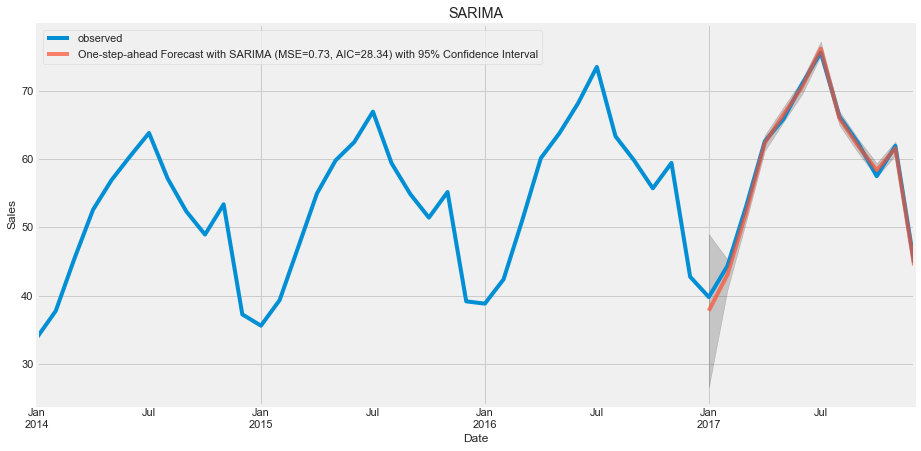

In [193]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step-ahead Forecast with SARIMA (MSE={:0.2f}, AIC={:0.2f}) with 95% Confidence Interval'.format(mse, results.aic), alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
ax.set_title("SARIMA");

# Holt-Winter's Seasonal Smoothing

In [189]:
# Holt-Winter's Seasonal Smoothing

model = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12, damped=True)

fit = model.fit()
pred_hw = fit.predict(start=pd.to_datetime('2017-01-01'))
fit2 = model2.fit()
pred_hw2 = fit2.predict(start=pd.to_datetime('2017-01-01'))

In [184]:
# Calculating Mean Squared Error
mse_hw = mean_squared_error(y['2017-01-01':],pred_hw)
mse_hw2 = mean_squared_error(y['2017-01-01':],pred_hw2)
print('The Mean Squared Error of our forecasts is {} w/o damping'.format(round(mse_hw, 2)))
print('The Mean Squared Error of our forecasts is {} with damping'.format(round(mse_hw2, 2)))

The Mean Squared Error of our forecasts is 2.19 w/o damping
The Mean Squared Error of our forecasts is 2.05 with damping


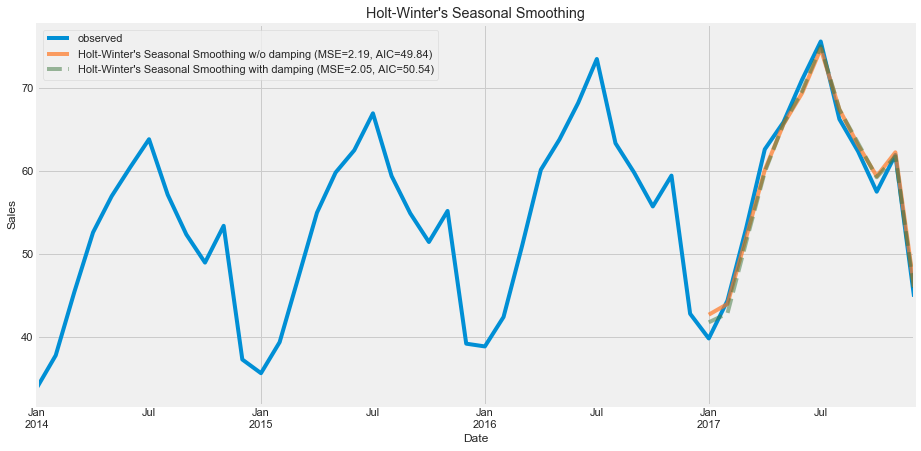

In [191]:
ax = y['2014':].plot(label='observed')
pred_hw.plot(ax=ax, label="Holt-Winter's Seasonal Smoothing w/o damping (MSE={:0.2f}, AIC={:0.2f})".format(mse_hw, fit.aic), alpha=.7, color='#ff7823', figsize=(14, 7))
pred_hw2.plot(ax=ax, label="Holt-Winter's Seasonal Smoothing with damping (MSE={:0.2f}, AIC={:0.2f})".format(mse_hw2, fit2.aic),linestyle='--', alpha=.5, color='#3c763d', figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
ax.set_title("Holt-Winter's Seasonal Smoothing");